# Import Packages

In [218]:

import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from pyomo.environ import*
import math
import csv
from IPython.display import display

from pyproj import Transformer 
from itertools import combinations
from shapely.geometry import LineString

import matplotlib.lines as mlines

# Access Files

Creating Dataframe of particular country and particular links

In [219]:
filename = 'LU.csv'
file_path = filename

country_df = pd.read_csv(file_path)

print(f"Shape of df is: {country_df.shape}")
#display(country_df)  

if (country_df['link_id'] == 7450).any():  # Check if any row has link_id 7450
    country_df = country_df[country_df['link_id'] != 7450]  # Keep rows where link_id is not 7450
print(f"Shape of df is: {country_df.shape}")



## Add scaling factor if needed to the x y positions for graphing and optimisation
# Infeasible when x y values are too large

scaling_factor = 0.1

# Scale 'src_x' and 'src_y' columns
country_df['src_x'] = country_df['src_x'] * scaling_factor
country_df['src_y'] = country_df['src_y'] * scaling_factor

# Scale 'dst_x' and 'dst_y' columns
country_df['dst_x'] = country_df['dst_x'] * scaling_factor
country_df['dst_y'] = country_df['dst_y'] * scaling_factor

display(country_df)


Shape of df is: (17, 18)
Shape of df is: (16, 18)


,link_id,src_bus_id,dst_bus_id,voltage,circuits,dc,underground,under_construction,length_m,tags,src_coord,dst_coord,src_country,dst_country,src_x,src_y,dst_x,dst_y
0,4825,3078,3082,220.0,1,f,f,f,15234.671583,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(5.976562, 49.482401)","(6.16333000000001, 49.560852)",LU,LU,66530.783853,635711.470361,68609.875719,637056.765001
1,4828,3083,3088,220.0,2,f,f,f,16754.971607,'text_'=>'(65)' 'symbol'=>'220 kV Transmissio...,"(6.17431599999999, 49.646291)","(5.94360399999999, 49.617828)",LU,LU,68732.171312,638524.352396,66163.897076,638035.157139
2,4831,3082,3088,220.0,2,f,f,f,16570.848910,'text_'=>'(65)' 'symbol'=>'220 kV Transmissio...,"(6.16333000000001, 49.560852)","(5.94360399999999, 49.617828)",LU,LU,68609.875719,637056.765001,66163.897076,638035.157139
3,4822,3081,3087,220.0,2,f,f,f,9835.749062,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(6.03149400000001, 49.539469)","(5.89965800000001, 49.560852)",LU,LU,67142.284080,636689.870668,65674.692441,637056.765001
4,4829,3078,3087,220.0,1,f,f,f,10050.248948,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(5.976562, 49.482401)","(5.89965800000001, 49.560852)",LU,LU,66530.783853,635711.470361,65674.692441,637056.765001
5,4640,2645,3086,220.0,1,f,f,f,12152.939771,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(6.26220699999999, 49.993615)","(6.17431599999999, 49.887557)",DE,LU,69710.569448,644517.014491,68732.171312,642682.541834
6,4827,3085,3086,220.0,1,f,f,f,12669.417784,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(6.108398, 49.781264)","(6.17431599999999, 49.887557)",LU,LU,67998.375492,640848.044140,68732.171312,642682.541834
7,4824,3087,4361,220.0,2,f,f,f,15625.042802,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(5.89965800000001, 49.560852)","(5.701904, 49.624946)",BE,LU,65674.692441,637056.765001,63473.304983,638157.467822
8,4832,2645,3085,220.0,2,f,f,f,26354.180634,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(6.26220699999999, 49.993615)","(6.108398, 49.781264)",DE,LU,69710.569448,644517.014491,67998.375492,640848.044140
9,4544,2645,3084,220.0,2,f,f,f,14289.423953,'text_'=>' ' 'symbol'=>'220 kV Transmission L...,"(6.26220699999999, 49.993615)","(6.053467, 49.993615)",DE,LU,69710.569448,644517.014491,67386.886397,644517.014491


## Functions
Calculate Forward Sector : Calculates the sector of an edge starting at the positive x axis going in counterclockwise direction. Sectors are split from 0 - 7.

![image.png](attachment:image.png)

# Function - NetworkX Implementation and Attributes

In [220]:
def calculate_forward_sector(src_x, src_y, dst_x, dst_y):
    dx = dst_x - src_x
    dy = dst_y - src_y
    
    # Angle in radians
    angle_rad = math.atan2(dy, dx)
    
    # Convert to degreees
    angle_deg = math.degrees(angle_rad)
    
    # Angle is rounded to nearest multiple of 45
    # Sector value calculated, modulo 8 used 
    sector = round(angle_deg / 45) % 8
    
    return sector





def euclidean_distance(src_x, src_y, dst_x, dst_y):
    dx = dst_x - src_x
    dy = dst_y - src_y
    
    return math.sqrt((dx)**2 + (dy)**2)




def get_non_incident_edge_pairs(G):
    non_incident_edge_pairs = []
    
    # combinations - generates all possible pairs of edges from graph G without repeating the same pair
    # '2' indicates we're looking for combinationes of 2 edges
    for edge1, edge2 in combinations(G.edges(), 2):
        
        # edges are sets and the '&' checks that they have no common elements (ie nodes)
        if not set(edge1) & set(edge2):
            non_incident_edge_pairs.append((edge1, edge2))
    return non_incident_edge_pairs    


def midpoint(pos1, pos2):
    """Calculate the midpoint between two positions."""
    return ((pos1[0] + pos2[0]) / 2, (pos1[1] + pos2[1]) / 2)



def calculate_distance(midpoint1, midpoint2):
    return math.sqrt((midpoint2[0] - midpoint1[0]) ** 2 + (midpoint2[1] - midpoint1[1]) ** 2)




def get_non_incident_edge_distance(G):
    non_incident_edge_distances = {}
    non_incident_edge_pairs = get_non_incident_edge_pairs(G)

    for edge1, edge2 in non_incident_edge_pairs:
        # Get the positions for the source and target nodes of each edge
        src_pos1, tgt_pos1 = G.nodes[edge1[0]]['pos'], G.nodes[edge1[1]]['pos']
        src_pos2, tgt_pos2 = G.nodes[edge2[0]]['pos'], G.nodes[edge2[1]]['pos']
        
        # Calculate the midpoints for each edge
        midpoint1 = midpoint(src_pos1, tgt_pos1)
        midpoint2 = midpoint(src_pos2, tgt_pos2)

        # Calculate the distance between the midpoints of the two edges
        dist = calculate_distance(midpoint1, midpoint2)

        # Store the distance with the edge pair as the key
        non_incident_edge_distances[(edge1, edge2)] = dist

    return non_incident_edge_distances




def calculate_angle(src_x, src_y, dst_x, dst_y):
    dx = dst_x - src_x
    dy = dst_y - src_y
    angle_radians = math.atan2(dy, dx)
    angle_degrees = math.degrees(angle_radians)  # Convert the angle to degrees
    
    # Normalize the angle to be within 0 to 360 degrees
    angle_degrees = (angle_degrees + 360) % 360

    return angle_degrees







 
def get_filtered_neighbour_order(G):
    
    # Convert the directed graph to an undirected graph to consider all adjacent nodes as neighbours
    G_undirected = G.to_undirected()
    
    # Create Dictionary to story nodes neighbour orders
    neighbour_order = {}
    for node in G_undirected.nodes():
        
        # Check if the node has 2 or more neighbours
        if G_undirected.degree(node) >= 2:
        
            # Access the position of the current node
            src_pos = G_undirected.nodes[node]['pos']
            src_x, src_y = src_pos
            
            # Create list to store angle size of neighbours with src node
            angles_neighbours = []
            
            
            
            for neighbour in G_undirected.neighbors(node):
                # Access the position tuple of the neighbour node using the 'pos' attribute
                dst_pos = G_undirected.nodes[neighbour]['pos']
                dst_x, dst_y = dst_pos
                
                # Calculate the angle from the source node to the neighbour node
                angle = calculate_angle(src_x, src_y, dst_x, dst_y)
                
                # Append the angle and neighbour to the list
                angles_neighbours.append((angle, neighbour)) 
                
                
            
            # Sort the list of (angle, neighbour) pairs by angle in ascending order
            angles_neighbours.sort()
            
            # Extract the sorted neighbours from the sorted list of pairs
            sorted_neighbours = [neighbour for _, neighbour in angles_neighbours]
            
            # Check conditions to move the last neighbour to the first position
            if angles_neighbours[-1][0] > 315 and ((360 - angles_neighbours[-1][0]) < angles_neighbours[0][0]):
                # Move the last neighbour to the first position
                sorted_neighbours.insert(0, sorted_neighbours.pop())
            
            
            # Store the sorted list of neighbours in the dictionary with the src_node as the key
            neighbour_order[node] = sorted_neighbours
    
    return neighbour_order
   

# NetworkX Implementation
Dataframe is accessed where nodes and edges are added to graph. 
Forward and backward sector of a particular edge are found and stored as attributes along with the voltage information.

In [221]:

# Initialize a directed graph since we have source and destination
G = nx.DiGraph()

# Loop through the DataFrame rows to add edges and nodes to the graph
for index, row in country_df.iterrows():
    src_node = row['src_bus_id']
    dst_node = row['dst_bus_id']
    voltage = row['voltage']
    
    # Add the source and destination nodes if they don't already exist
    if src_node not in G:
        G.add_node(src_node, pos=(row['src_x'], row['src_y']))
    if dst_node not in G:
        G.add_node(dst_node, pos=(row['dst_x'], row['dst_y']))
        
        
        
    # Calculate the forward sector for edges
    forward_sector = calculate_forward_sector(row['src_x'], row['src_y'], row['dst_x'], row['dst_y'])

    # Backward sector
    backward_sector = (forward_sector + 4) % 8
    
    distance = euclidean_distance(row['src_x'], row['src_y'], row['dst_x'], row['dst_y'])
    
    # Add an edge between the source and destination nodes, voltage is attribute
    G.add_edge(src_node, dst_node, 
               voltage = voltage, 
               forward_sector = forward_sector, 
               backward_sector = backward_sector,
               distance = distance
               )


# Create list of non-incident edge pairs
non_incident_edge_pairs = get_non_incident_edge_pairs(G)

print(non_incident_edge_pairs)



# Print non-incident edge pairs
print("Non-incident edge pairs:")
for edge_pair in non_incident_edge_pairs:
    print(edge_pair)
    
ordered_neighbours_dict = get_filtered_neighbour_order(G)
print("\nNodes with more than 2 neighbours ordered:")
print(ordered_neighbours_dict)
for node, neighbours in ordered_neighbours_dict.items():
    print(len(neighbours))
    
    
 # dictionary
non_incident_edge_distances = get_non_incident_edge_distance(G)

# Find the non-incident edge pair with the maximum distance
max_distance_pair = max(non_incident_edge_distances, key=non_incident_edge_distances.get)

# Print the non-incident edge pair with the maximum distance and its value
max_distance_value = non_incident_edge_distances[max_distance_pair]
print(f"Non-incident edge pair with maximum distance: {max_distance_pair} with distance {max_distance_value}")
 

[((3078, 3082), (3083, 3088)), ((3078, 3082), (3081, 3087)), ((3078, 3082), (3087, 4361)), ((3078, 3082), (2645, 3086)), ((3078, 3082), (2645, 3085)), ((3078, 3082), (2645, 3084)), ((3078, 3082), (3085, 3086)), ((3078, 3082), (2646, 3084)), ((3078, 3082), (3079, 3083)), ((3078, 3082), (3079, 3085)), ((3078, 3087), (3082, 3088)), ((3078, 3087), (3082, 3083)), ((3078, 3087), (3083, 3088)), ((3078, 3087), (3081, 3082)), ((3078, 3087), (2645, 3086)), ((3078, 3087), (2645, 3085)), ((3078, 3087), (2645, 3084)), ((3078, 3087), (3085, 3086)), ((3078, 3087), (2646, 3084)), ((3078, 3087), (3079, 3083)), ((3078, 3087), (3079, 3085)), ((3078, 3087), (3080, 3082)), ((3082, 3088), (3081, 3087)), ((3082, 3088), (3087, 4361)), ((3082, 3088), (2645, 3086)), ((3082, 3088), (2645, 3085)), ((3082, 3088), (2645, 3084)), ((3082, 3088), (3085, 3086)), ((3082, 3088), (2646, 3084)), ((3082, 3088), (3079, 3083)), ((3082, 3088), (3079, 3085)), ((3082, 3083), (3081, 3087)), ((3082, 3083), (3087, 4361)), ((3082, 3

## Drawing NetworkX Graph

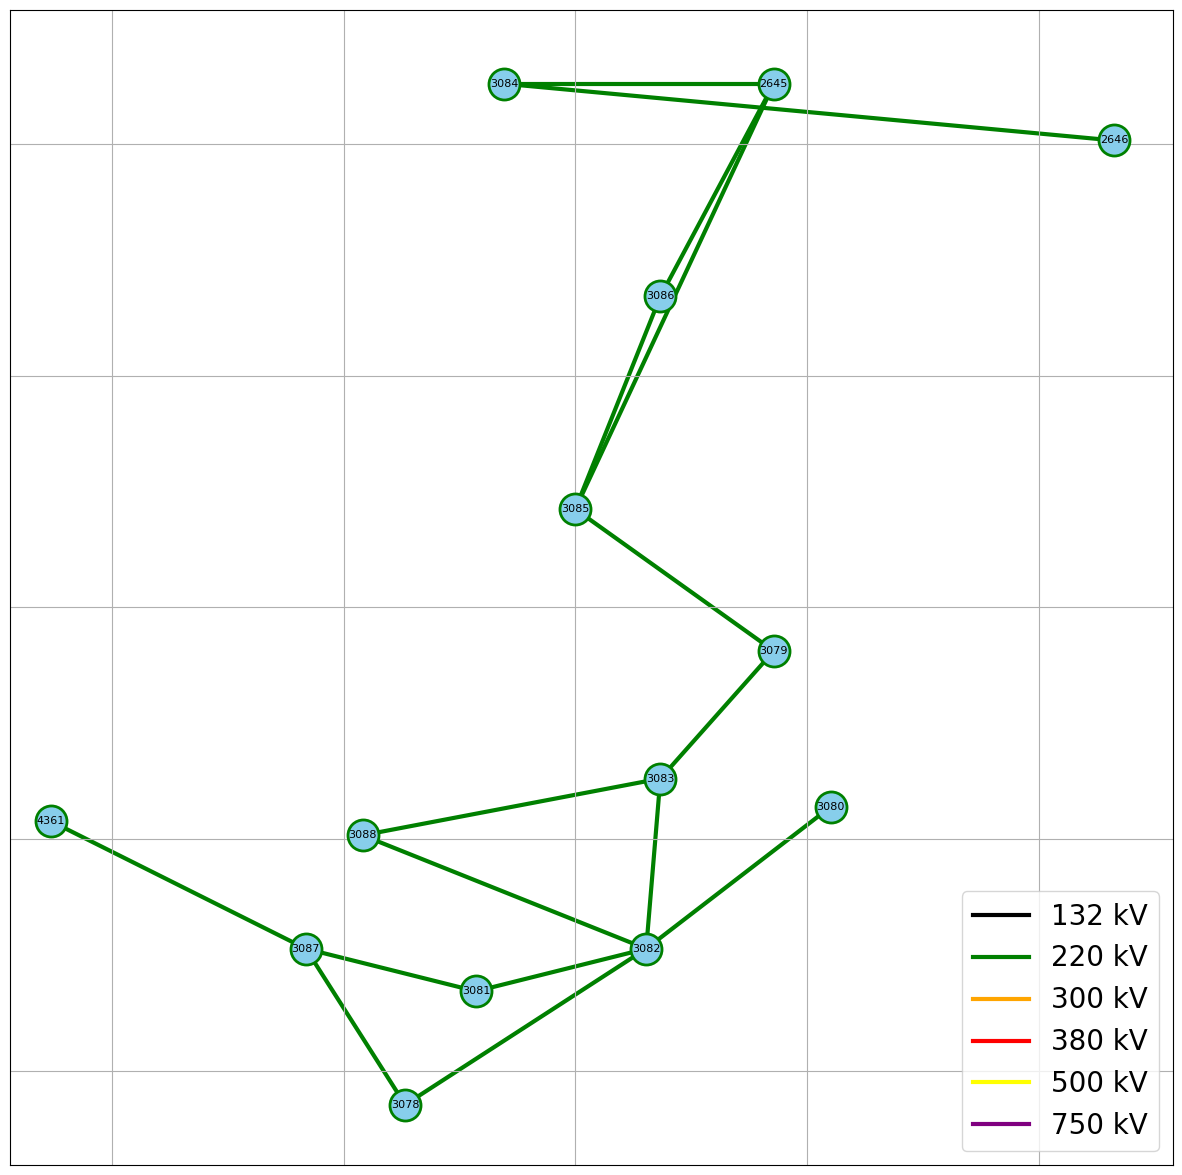

In [222]:

pos = nx.get_node_attributes(G, 'pos')



""" def highest_voltage_color(G, node):
    # Get highest voltage of all connected edges
    highest_voltage = max((d['voltage'] for u, v, d in G.edges(node, data=True)), default=0)
    return voltage_colors.get(highest_voltage, 'grey')      #default colout """


def draw_graph(G, pos):
    plt.figure(figsize=(15, 15))
    
    # Convert to undirected graph for the purpose of finding node outline colors
    G_undirected = G.to_undirected()

    voltage_colors = {
        132: 'black',
        220: 'green',
        380: 'red',
        300: 'orange',
        500: 'yellow',
        750: 'purple'
    }

    # Determine the highest voltage color for each node
    node_outline_color = {}
    for node in G.nodes():
        connected_edges = G_undirected.edges(node, data=True)
        highest_voltage = max((data['voltage'] for _, _, data in connected_edges), default=0)
        node_outline_color[node] = voltage_colors.get(highest_voltage, 'grey')

    # Draw nodes with highest voltage outline color
    for node, color in node_outline_color.items():
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='skyblue',
                               edgecolors=color, node_size=500, linewidths=2)


    # Define custom lines for the legend with appropriate colors and labels for each voltage level
    legend_lines = [
        
        mlines.Line2D([], [], color='black', markersize=30, label='132 kV', linewidth=3),
        mlines.Line2D([], [], color='green', markersize=30, label='220 kV', linewidth=3),
        mlines.Line2D([], [], color='orange', markersize=30, label='300 kV', linewidth=3),
        mlines.Line2D([], [], color='red', markersize=30, label='380 kV', linewidth=3),
        mlines.Line2D([], [], color='yellow', markersize=30, label='500 kV', linewidth=3),
        mlines.Line2D([], [], color='purple', markersize=30, label='750 kV', linewidth=3)
    ]

    # Draw the graph edges with different colors based on the voltage
    for (u, v, d) in G.edges(data=True):
        if d['voltage'] == 380:
            edge_color = 'red'
        elif d['voltage'] == 220:
            edge_color = 'green'
        elif d['voltage'] == 132:
            edge_color = 'black'
        elif d['voltage'] == 300:
            edge_color = 'orange'
        elif d['voltage'] == 500:
            edge_color = 'yellow'
        elif d['voltage'] == 750:
            edge_color = 'purple'
        else:
            edge_color = 'grey'  # Default color for unspecified or unknown voltages
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=edge_color, width=3, arrows=False)

    # Draw the node labels
    nx.draw_networkx_labels(G, pos, font_size=8)

    # Create edge labels for voltages, using 'link_id' or another attribute if desired
    edge_labels = nx.get_edge_attributes(G, 'link_id')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_size=7)

    # Add the legend to the plot with all line types
    plt.legend(handles=legend_lines, loc='lower right', fontsize=20)
    plt.axis('equal')
    plt.grid(True)
    # Show the plot
    plt.show()
    
    
draw_graph(G, pos)


## Access edge information from NetworkX Graph

In [223]:
def get_edge_info(G, edge):
    node1, node2 = edge
    
    # edge attributes eg voltage forward/backward sector are stored in edge data
    edge_data = G.get_edge_data(node1, node2)
    
    # Additional edge information
    edge_information = {
        'edge': edge,
        'source': node1,
        'destination': node2,
        'source_position': G.nodes[node1].get('pos'),
        'destination_position': G.nodes[node2].get('pos'),
        'source_neighbors': list(G.successors(node1)),  # or list(G.successors(u)) for DiGraph
        'destination_neighbors': list(G.predecessors(node2)),  # or list(G.predecessors(v)) for DiGraph
        'source_degree': G.degree(node1),
        'destination_degree': G.degree(node2)
    }
    
    # Merge edge_data into edge_info
    edge_information.update(edge_data)
    return edge_information

    
    
# Print Specified Edge Details
edge_details = {}
for edge in G.edges():
    edge_details[edge] = get_edge_info(G, edge)
    print(edge_details[edge])
    
    forward = edge_details[edge].get('forward_sector')
    backward = edge_details[edge].get('backward_sector')
    print(f"Forward sector for edge {edge}: {forward}")
    print(f"Backward sector for edge {edge}: {backward}\n") 
    


{'edge': (3078, 3082), 'source': 3078, 'destination': 3082, 'source_position': (66530.78385344287, 635711.4703607099), 'destination_position': (68609.87571909079, 637056.7650013121), 'source_neighbors': [3082, 3087], 'destination_neighbors': [3078, 3081, 3080], 'source_degree': 2, 'destination_degree': 5, 'voltage': 220.0, 'forward_sector': 1, 'backward_sector': 5, 'distance': 2476.376517381057}
Forward sector for edge (3078, 3082): 1
Backward sector for edge (3078, 3082): 5

{'edge': (3078, 3087), 'source': 3078, 'destination': 3087, 'source_position': (66530.78385344287, 635711.4703607099), 'destination_position': (65674.6924414464, 637056.7650013121), 'source_neighbors': [3082, 3087], 'destination_neighbors': [3081, 3078], 'source_degree': 2, 'destination_degree': 3, 'voltage': 220.0, 'forward_sector': 3, 'backward_sector': 7, 'distance': 1594.5877761124043}
Forward sector for edge (3078, 3087): 3
Backward sector for edge (3078, 3087): 7

{'edge': (3082, 3088), 'source': 3082, 'dest

In [224]:
# Debugging to check the sectors around the node 6188

# Usage example
edge_details = {}
for edge in G.edges():
    # Check if the node 6188 is part of the edge
    if 6188 in edge:
        edge_details[edge] = get_edge_info(G, edge)
        print(edge_details[edge])
        
        forward = edge_details[edge].get('forward_sector')
        backward = edge_details[edge].get('backward_sector')
        print(f"Forward sector for edge {edge}: {forward}")
        print(f"Backward sector for edge {edge}: {backward}\n") 


Create Dictionary of initial lengths of each edge

In [225]:
initial_lengths = {}

for edge in G.edges():
    edge_info = get_edge_info(G, edge)  # Retrieve edge information

    # Assuming the 'get_edge_info' function returns a dictionary with the positions
    node1_pos = edge_info.get('source_position')  # Source position (x, y)
    node2_pos = edge_info.get('destination_position')  # Destination position (x, y)

    # Calculate the Euclidean distance between node1 and node2
    distance = euclidean_distance(node1_pos[0], node1_pos[1], node2_pos[0], node2_pos[1])

    # Store the distance in the initial_lengths dictionary using the edge as the key
    initial_lengths[edge] = distance

print(initial_lengths)    

{(3078, 3082): 2476.376517381057, (3078, 3087): 1594.5877761124043, (3082, 3088): 2634.3998746776983, (3082, 3083): 1472.674089448507, (3083, 3088): 2614.4491868555447, (3081, 3087): 1512.7579681166385, (3081, 3082): 1512.7579681166667, (3087, 4361): 2461.2300665971034, (2645, 3086): 2079.0749967314805, (2645, 3085): 4048.8210113333585, (2645, 3084): 2323.683050818683, (3085, 3086): 1975.8132745674527, (2646, 3084): 5281.569784198199, (3079, 3083): 1472.691375611001, (3079, 3085): 2104.114690863599, (3080, 3082): 2005.857191176925}


# Functions - Optimisation

### Octilinearity Constraints Functions
- Getting Dynamic Minimum Edge Length

In [226]:
# to get dynamic min length 
# Minimum length percentage
def calculate_dynamic_min_lengths(G, min_length_horizontal, min_length_diagonal):
    # Dictionary to store dynamic minimum lengths for each edge
    dynamic_min_lengths = {}

    for edge in G.edges():
        edge_info = get_edge_info(G, edge)

        forward = edge_info.get('forward_sector')
        backward = edge_info.get('backward_sector')

        if forward in (1, 3, 5, 7) or backward in (1, 3, 5, 7):
            # Use the diagonal minimum length for diagonal edges
            #dynamic_min_length = edge_info['distance'] * min_length_diagonal
            dynamic_min_length = 1400
        else:
            # Use the horizontal minimum length for horizontal/vertical edges
            #dynamic_min_length = edge_info['distance'] * min_length_horizontal
            dynamic_min_length = 1400

        # Store the calculated dynamic minimum length in the dictionary
        dynamic_min_lengths[edge] = dynamic_min_length

    return dynamic_min_lengths
    
    
dynamic_min_lengths = calculate_dynamic_min_lengths(G, 0.2, 0.22)


print(dynamic_min_lengths) 

{(3078, 3082): 1400, (3078, 3087): 1400, (3082, 3088): 1400, (3082, 3083): 1400, (3083, 3088): 1400, (3081, 3087): 1400, (3081, 3082): 1400, (3087, 4361): 1400, (2645, 3086): 1400, (2645, 3085): 1400, (2645, 3084): 1400, (3085, 3086): 1400, (2646, 3084): 1400, (3079, 3083): 1400, (3079, 3085): 1400, (3080, 3082): 1400}


### Circular Vertex Order Constraints Functions

In [227]:
## Function to get index of nodes in the ordered neighbours list.

# This function initializes the set of (node, index) pairs, where 'node' is a node with 2 or more neighbors,
# and 'index' is a unique integer (starting from 1) representing the position of a neighbor in the
# counterclockwise ordering of neighbors around 'node'.

def node_neighbour_index_pairs_init(model):
    node_index_pairs = []
    for node, neighbors in ordered_neighbours_dict.items():
        # Start index from 0 for each node's neighbors
        for idx in range(0, len(neighbors)):
            node_index_pairs.append((node, idx))
    return node_index_pairs



## Helper Function for the circular vertex order
## Determines if node with more than 2 neighbours is the source or destination node
## So the correct direction can be assigned to it

def directional_sector(model, node, neighbor):
    if (node, neighbor) in model.Edges:
        return model.dir_forward[node, neighbor]
    elif (neighbor, node) in model.Edges:
        return model.dir_backward[neighbor, node]
    else:
        return None  # This case should ideally never happen if the graph is well-defined

### Edge Spacing Constraints Functions
Gets list of intersecting edges and new list of non intersecting non incident edges created

In [228]:


def list_edge_intersections(G):
    intersecting_edge_pairs = []
    non_incident_edge_pairs = get_non_incident_edge_pairs(G)

    for edge1, edge2 in non_incident_edge_pairs:
        # Get the positions for the source and target nodes of each edge
        src_pos1, tgt_pos1 = G.nodes[edge1[0]]['pos'], G.nodes[edge1[1]]['pos']
        src_pos2, tgt_pos2 = G.nodes[edge2[0]]['pos'], G.nodes[edge2[1]]['pos']
        
        # Create LineString objects for each edge
        line1 = LineString([src_pos1, tgt_pos1])
        line2 = LineString([src_pos2, tgt_pos2])

        # Check if the two edges intersect
        if line1.intersects(line2):
            # If they intersect, add the edge pair to the list
            intersecting_edge_pairs.append((edge1, edge2))

    return intersecting_edge_pairs

# Call the function to get intersecting edge pairs
intersecting_edges = list_edge_intersections(G)

# Print the intersecting edge pairs
for edge_pair in intersecting_edges:
    print(f"Intersecting Edge Pair: {edge_pair}")

Intersecting Edge Pair: ((2645, 3086), (2646, 3084))
Intersecting Edge Pair: ((2645, 3085), (2646, 3084))


In [229]:
# Create a new list excluding intersecting edge pairs
non_intersecting_non_incident_edges = [edge_pair for edge_pair in non_incident_edge_pairs if edge_pair not in intersecting_edges]

# Print the new list of non-intersecting, non-incident edge pairs
for edge_pair in non_intersecting_non_incident_edges:
    print(f"Non-Intersecting Non-Incident Edge Pair: {edge_pair}")

Non-Intersecting Non-Incident Edge Pair: ((3078, 3082), (3083, 3088))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3082), (3081, 3087))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3082), (3087, 4361))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3082), (2645, 3086))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3082), (2645, 3085))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3082), (2645, 3084))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3082), (3085, 3086))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3082), (2646, 3084))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3082), (3079, 3083))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3082), (3079, 3085))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3087), (3082, 3088))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3087), (3082, 3083))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3087), (3083, 3088))
Non-Intersecting Non-Incident Edge Pair: ((3078, 3087), (3081, 3082))
Non-Intersecting Non

# Optimisation

## Variables and Parameters

In [230]:
model = ConcreteModel()



""" print(list(G.nodes()))
print(list(G.edges())) """
# Set used to index the other components eg Param and Var, and to define the scope
model.Nodes = Set(initialize = list(G.nodes()))
model.Edges = Set(initialize = list(G.edges()))

# Initialize set of non-incident edge pairs
# dimen = 4: creates a collection of edge pairs where each pair is treated as a single tuple, 2 integers per edge
model.NonIncidentEdges = Set(initialize = non_incident_edge_pairs, dimen=4)
model.NonIntersecting_NonIncidentEdges = Set(initialize = non_intersecting_non_incident_edges, dimen=4)
model.IntersectingEdgePairs = Set(initialize = intersecting_edges, dimen = 4)


# Set with 2 or more neighbours
# Storing set nodes with 2 or more neighbours that were predetermined in the dictionary
model.NodesWith2Neighbours = Set(initialize = ordered_neighbours_dict.keys())


# Initialize the set with the function that provides the (node, index) pairs
model.NodeNeighbours2IndexPairs = Set(dimen=2, initialize=node_neighbour_index_pairs_init)





### PARAM ###
## Param - fixed value in model that doesn't change during optimisation process ##
# pos defined earlier as tuple (x, y) in graph G
model.x_init = Param(model.Nodes, initialize={node: pos[node][0] for node in G.nodes()})
model.y_init = Param(model.Nodes, initialize={node: pos[node][1] for node in G.nodes()})


# Access information from dictionary of the edge info
edge_info = {edge: get_edge_info(G, edge) for edge in G.edges()}

# Initialize Params for static attributes from the edges
model.voltage = Param(model.Edges, initialize={edge: edge_info[edge]['voltage'] for edge in model.Edges})
model.sect_forward = Param(model.Edges, initialize={edge: edge_info[edge]['forward_sector'] for edge in model.Edges})
model.sect_backward = Param(model.Edges, initialize={edge: edge_info[edge]['backward_sector'] for edge in model.Edges})
model.distance = Param(model.Edges, initialize={edge: edge_info[edge]['distance'] for edge in model.Edges} )
#model.non_incident_edges = Param(model.Edges, initialize = {edge: edge_info[edge]['non_incident_edges'] for edge in model.Edges} )


# Param to store the ordered neighbors for each node in the model
model.OrderedNeighbours = Param(
    model.NodesWith2Neighbours,  # Index set for the Param, representing nodes with 2 or more neighbors
    within=Any,  # Specifies that the Param can hold any type of data, in this case, tuples of nodes
    initialize=lambda model, node: tuple(ordered_neighbours_dict[node])  # Initialization function
    # lambda function takes 2 arguments model and node (element from set Nodewith2Neigbours)
    # for each node, it gets the list or ordered neighbours from the dictionary
    # list is converted to tuple so that for Param, the contents are unchangeable
)
   





### VARIABLES ###
## Define Variables ##
model.x_pos = Var(model.Nodes, within = Reals, initialize = model.x_init)
model.y_pos = Var(model.Nodes, within = Reals, initialize = model.y_init)

model.z1_pos = Expression(model.Nodes, rule = lambda model, node: model.x_pos[node] + model.y_pos[node])
model.z2_pos = Expression(model.Nodes, rule = lambda model, node: model.x_pos[node] - model.y_pos[node])


model.dir_forward = Var(model.Edges, within = Integers, bounds = (0, 7))
model.dir_backward = Var(model.Edges, within = Integers, bounds = (0, 7))


# Binary variable for octilinear constraint to determine where edge is drawn
model.alpha_pred = Var(model.Edges, within = Binary, bounds = (0, 1))
model.alpha_orig = Var(model.Edges, within = Binary, bounds = (0, 1))
model.alpha_succ = Var(model.Edges, within = Binary, bounds = (0, 1))


# Binary Variable for non-incident edge constraint
model.is_N = Var(model.NonIncidentEdges, within=Binary)
model.is_S = Var(model.NonIncidentEdges, within=Binary)
model.is_E = Var(model.NonIncidentEdges, within=Binary)
model.is_W = Var(model.NonIncidentEdges, within=Binary)
model.is_NE = Var(model.NonIncidentEdges, within=Binary)
model.is_NW = Var(model.NonIncidentEdges, within=Binary)
model.is_SE = Var(model.NonIncidentEdges, within=Binary)
model.is_SW = Var(model.NonIncidentEdges, within=Binary)

model.delta_pred = Var(model.Edges, within = Integers, bounds = (0, 7))
model.delta_orig = Var(model.Edges, within = Integers, bounds = (0, 7))
model.delta_succ = Var(model.Edges, within = Integers, bounds = (0, 7))


max_degree = max(len(neighbors) for neighbors in ordered_neighbours_dict.values())


# Define Beta as a binary variable indexed by the (node, index) pairs
# Beta[node, idx] will be used in the constraints to identify the "wrap-around" point
# in the counterclockwise ordering of neighbors around each node
model.Beta = Var(model.NodeNeighbours2IndexPairs, within=Binary)




# Redefine rpos as a continuous variable representing the deviation magnitude
model.rpos = Var(model.Edges, within=NonNegativeReals)


model.dev_pos = Var(model.Edges, within=NonNegativeReals)
model.dev_neg = Var(model.Edges, within=NonNegativeReals)

tolerance = 0.01






model.min_dist_x_pos = Var(model.IntersectingEdgePairs, within=NonNegativeReals)
model.min_dist_x_neg = Var(model.IntersectingEdgePairs, within=NonNegativeReals)
model.min_dist_y_pos = Var(model.IntersectingEdgePairs, within=NonNegativeReals)
model.min_dist_y_neg = Var(model.IntersectingEdgePairs, within=NonNegativeReals)










# Lower and upper bound factors
lower_bound_factor = 0.5  # e.g., 50% of the initial length
upper_bound_factor = 4  # e.g., 150% of the initial length

# Lower absolute threshold for very short edges
absolute_lower_threshold = 500  # Some unit length that makes sense for your graph's scale

# Define min_length as a variable for each edge
model.min_length = Var(model.Edges, within=NonNegativeReals, initialize=initial_lengths,
                       bounds=lambda model, u, v: (
                           max(absolute_lower_threshold, initial_lengths[u, v] * lower_bound_factor),
                           initial_lengths[u, v] * upper_bound_factor))





In [231]:
""" # Define a ConstraintList for spacing constraints
model.EdgeSpacingConstraints = ConstraintList()

dmin = 50  # Minimum spacing distance, as an example

# Define the constraints
def enforce_minimum_spacing(model, u1, v1, u2, v2):
    # Constraints for node u2 to be at least dmin away from nodes u1 and v1
    model.EdgeSpacingConstraints.add(model.x_pos[u2] - model.x_pos[u1] >= dmin)
    model.EdgeSpacingConstraints.add(model.x_pos[u1] - model.x_pos[u2] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[u2] - model.y_pos[u1] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[u1] - model.y_pos[u2] >= dmin)

    model.EdgeSpacingConstraints.add(model.x_pos[u2] - model.x_pos[v1] >= dmin)
    model.EdgeSpacingConstraints.add(model.x_pos[v1] - model.x_pos[u2] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[u2] - model.y_pos[v1] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[v1] - model.y_pos[u2] >= dmin) 

    # Constraints for node v2 to be at least dmin away from nodes u1 and v1
    model.EdgeSpacingConstraints.add(model.x_pos[v2] - model.x_pos[u1] >= dmin)
    model.EdgeSpacingConstraints.add(model.x_pos[u1] - model.x_pos[v2] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[v2] - model.y_pos[u1] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[u1] - model.y_pos[v2] >= dmin)

    model.EdgeSpacingConstraints.add(model.x_pos[v2] - model.x_pos[v1] >= dmin)
    model.EdgeSpacingConstraints.add(model.x_pos[v1] - model.x_pos[v2] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[v2] - model.y_pos[v1] >= dmin)
    model.EdgeSpacingConstraints.add(model.y_pos[v1] - model.y_pos[v2] >= dmin) 

# Adding the constraints to the model for each pair of intersecting edges
for (u1, v1, u2, v2) in model.IntersectingEdgePairs:
    enforce_minimum_spacing(model, u1, v1, u2, v2)
 """


' # Define a ConstraintList for spacing constraints\nmodel.EdgeSpacingConstraints = ConstraintList()\n\ndmin = 50  # Minimum spacing distance, as an example\n\n# Define the constraints\ndef enforce_minimum_spacing(model, u1, v1, u2, v2):\n    # Constraints for node u2 to be at least dmin away from nodes u1 and v1\n    model.EdgeSpacingConstraints.add(model.x_pos[u2] - model.x_pos[u1] >= dmin)\n    model.EdgeSpacingConstraints.add(model.x_pos[u1] - model.x_pos[u2] >= dmin)\n    model.EdgeSpacingConstraints.add(model.y_pos[u2] - model.y_pos[u1] >= dmin)\n    model.EdgeSpacingConstraints.add(model.y_pos[u1] - model.y_pos[u2] >= dmin)\n\n    model.EdgeSpacingConstraints.add(model.x_pos[u2] - model.x_pos[v1] >= dmin)\n    model.EdgeSpacingConstraints.add(model.x_pos[v1] - model.x_pos[u2] >= dmin)\n    model.EdgeSpacingConstraints.add(model.y_pos[u2] - model.y_pos[v1] >= dmin)\n    model.EdgeSpacingConstraints.add(model.y_pos[v1] - model.y_pos[u2] >= dmin) \n\n    # Constraints for node v2 t

## Octilinearity Constraint

In [232]:
# Sum of Binary variables is equal to 1
# node1 and node2 are the src and dst nodes defined in model.Edges
def alpha_direction_constraint(model, node1, node2):
    return model.alpha_pred[node1, node2] + model.alpha_orig[node1, node2] + model.alpha_succ[node1, node2] == 1
model.alpha_direction_constraint = Constraint(model.Edges, rule = alpha_direction_constraint)


 
 # for each edge in tuple (node1, node2) in model.Edges, dir constraint is called and formed
def dir_forward_constraint(model, node1, node2):
    
    
    sect_forward_pred = (model.sect_forward[node1, node2] - 1) % 8
    sect_forward_orig = model.sect_forward[node1, node2]
    sect_forward_succ = (model.sect_forward[node1, node2] + 1) % 8
    
     # Debugging: Print the values of sectors and binary variables
    """ print(f"Edge: {(node1, node2)}")
    print(f"sect_forward_pred: {sect_forward_pred}, sect_forward_orig: {sect_forward_orig}, sect_forward_succ: {sect_forward_succ}")
    print(f"alpha_pred[{node1}, {node2}]: {model.alpha_pred[node1, node2].value}")
    print(f"alpha_orig[{node1}, {node2}]: {model.alpha_orig[node1, node2].value}")
    print(f"alpha_succ[{node1}, {node2}]: {model.alpha_succ[node1, node2].value}") """
    
    
    
    return model.dir_forward[node1, node2] == ((sect_forward_pred * model.alpha_pred[node1, node2]) +
                                        (sect_forward_orig * model.alpha_orig[node1, node2]) +
                                        (sect_forward_succ * model.alpha_succ[node1, node2])
                                        )

model.DirForwardConstraint = Constraint(model.Edges, rule=dir_forward_constraint)
 

def dir_backward_constraint(model, node1, node2):
    sect_backward_pred = (model.sect_backward[node1, node2] - 1) % 8
    sect_backward_orig = model.sect_backward[node1, node2]
    sect_backward_succ = (model.sect_backward[node1, node2] + 1) % 8
    
      # Debugging: Print the values of sectors and binary variables
    """ print(f"Edge: {(node1, node2)}")
    print(f"sect_backward_pred: {sect_backward_pred}, sect_backward_orig: {sect_backward_orig}, sect_backward_succ: {sect_backward_succ}")
    print(f"alpha_pred[{node1}, {node2}]: {model.alpha_pred[node1, node2].value}")
    print(f"alpha_orig[{node1}, {node2}]: {model.alpha_orig[node1, node2].value}")
    print(f"alpha_succ[{node1}, {node2}]: {model.alpha_succ[node1, node2].value}")  """
    
    return model.dir_backward[node1, node2] == ((sect_backward_pred * model.alpha_pred[node1, node2]) +
                                        (sect_backward_orig * model.alpha_orig[node1, node2]) +
                                        (sect_backward_succ * model.alpha_succ[node1, node2])
                                        )
    
model.DirBackwardConstraint = Constraint(model.Edges, rule = dir_backward_constraint) 




 
def sector_constraints_rule(model, node1, node2):

    # Retrieve original sector and minimum edge length
    sect_orig = model.sect_forward[node1, node2]
    min_length = 1600 #dynamic_min_lengths[(node1, node2)] #(model.distance[node1, node2])*0.1  #1000
    #min_length = model.min_length[node1, node2]
    
    
    # Define a large constant M for making constraints trivial when not active
    M = 30000  # Adjust as needed

    # Iterate over each alpha variable and its corresponding sector adjustment
    for alpha, adjustment in zip([model.alpha_pred, model.alpha_orig, model.alpha_succ], [-1, 0, 1]):
        # Adjusted sector based on alpha variable
        sect_adjusted = (sect_orig + adjustment) % 8

        # Conditions based on adjusted sector
        if sect_adjusted in [0, 4]:  # Horizontal
            model.sector_constraints.add(model.y_pos[node1] - model.y_pos[node2] <= M * (1 - alpha[node1, node2]))
            model.sector_constraints.add(-model.y_pos[node1] + model.y_pos[node2] <= M * (1 - alpha[node1, node2]))
            
            if sect_adjusted == 0:
                # For sector 0, node1 should be to the left of node2 by at least min_length if this direction is selected
                model.sector_constraints.add(model.x_pos[node2] - model.x_pos[node1] >= min_length - M * (1 - alpha[node1, node2]))
                
                """ model.sector_constraints.add(model.dev_pos[node1, node2] >= model.y_pos[node2] - model.y_pos[node1] - tolerance)
                model.sector_constraints.add(model.dev_neg[node1, node2] >= -model.y_pos[node2] + model.y_pos[node1] - tolerance) """
                
                
                
                
                
            elif sect_adjusted == 4:
                # For sector 4, node1 should be to the right of node2 by at least min_length if this direction is selected
                model.sector_constraints.add(model.x_pos[node1] - model.x_pos[node2] >= min_length - M * (1 - alpha[node1, node2]))
                
                """ model.sector_constraints.add(model.dev_pos[node1, node2] >= model.y_pos[node2] - model.y_pos[node1] - tolerance)
                model.sector_constraints.add(model.dev_neg[node1, node2] >= -model.y_pos[node2] + model.y_pos[node1] - tolerance)
         """
         
         
         
         
         
        
        elif sect_adjusted in [2, 6]:  # Vertical
            # Add corresponding constraints for this sector
            model.sector_constraints.add(model.x_pos[node1] - model.x_pos[node2] <= M*(1 - alpha[node1, node2]))
            model.sector_constraints.add(-model.x_pos[node1] + model.x_pos[node2] <= M*(1 - alpha[node1, node2]))
            
            if sect_adjusted == 2:  # Upwards
                # Node2's y_pos should be at least min_length above Node1's y_pos
                model.sector_constraints.add(model.y_pos[node2] - model.y_pos[node1] >= min_length - M * (1 - alpha[node1, node2]))
                """ 
                model.sector_constraints.add(model.dev_pos[node1, node2] >= model.x_pos[node2] - model.x_pos[node1] - tolerance)
                model.sector_constraints.add(model.dev_neg[node1, node2] >= -model.x_pos[node2] + model.x_pos[node1] - tolerance)
                """
            
            
            
            
            elif sect_adjusted == 6:  # Downwards
                # Node2's y_pos should be at least min_length below Node1's y_pos
                model.sector_constraints.add(model.y_pos[node1] - model.y_pos[node2] >= min_length - M * (1 - alpha[node1, node2]))

                """ model.sector_constraints.add(model.dev_pos[node1, node2] >= model.x_pos[node2] - model.x_pos[node1] - tolerance)
                model.sector_constraints.add(model.dev_neg[node1, node2] >= -model.x_pos[node2] + model.x_pos[node1] - tolerance) """
        





        elif sect_adjusted == 1:         #upright diagonal /
            # dx = dy
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) <= M*(1 - alpha[node1, node2]))
            model.sector_constraints.add((model.y_pos[node2] - model.y_pos[node1]) - (model.x_pos[node2] - model.x_pos[node1]) <= M*(1 - alpha[node1, node2]))
            # dx + dy >= min length of diagonal
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M*(1 - alpha[node1, node2]))
            
            """ model.sector_constraints.add(model.dev_pos[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.sector_constraints.add(model.dev_neg[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance) """
        
            
            
            
        elif sect_adjusted == 5:        # Diagonal downwards /
            # dx = -dy
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) <= M*(1 - alpha[node1, node2]))
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) <= M*(1 - alpha[node1, node2]))
            # -dx - dy >= min length
            # negative diagonal
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M*(1 - alpha[node1, node2]))


            """ model.sector_constraints.add(model.dev_pos[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.sector_constraints.add(model.dev_neg[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance) """
        
            


            
        ## Diagonal \
            
        elif sect_adjusted == 3:    # Up left diagonal \
            # -dx = dy
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) <= M * (1 - alpha[node1, node2]))
            
            # Ensure dx is negative
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) <= 0)
            
            # -dx + dy >= min length (dx is negative value)
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M * (1 - alpha[node1, node2]))
            
            
            """ model.sector_constraints.add(model.dev_pos[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.sector_constraints.add(model.dev_neg[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
         """
            
            
        elif sect_adjusted == 7:    # Down right Diagonal \
            # dx = -dy
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) <= M * (1 - alpha[node1, node2]))
            
            # Ensure dy is negative
            model.sector_constraints.add((model.y_pos[node2] - model.y_pos[node1]) <= 0)
        
            # dx - dy >= min length (since dy is negative, we use -dy)
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M * (1 - alpha[node1, node2]))
            """ 
            model.sector_constraints.add(model.dev_pos[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.sector_constraints.add(model.dev_neg[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            """




       



       
            # Fill in your constraints similar to above
    return Constraint.Skip 

# Initialize the constraint list on your model if not already done
model.sector_constraints = ConstraintList()

# Apply the rule to each edge
model.SectorConstraint = Constraint(model.Edges, rule=sector_constraints_rule)

 
 

  

   


## Circular Vertex Order
The initial circular ordering of neighbour nodes (counterclockwise) should be the same after optimisation.

For each node in the map, the sequence in which the neighbouring nodes are arranged around a particular node should match the order in which the neighbouring nodes are arranged in the final layout.

In [233]:
# Beta Binary Sum Constraint


def beta_sum_constraint_rule(model, node):
    # Ensure we use 0-based indexing to match the updated indexing in Beta
    # Note that RangeSet in Pyomo starts from 1, so we adjust the range accordingly
    return sum(model.Beta[node, index] for index in range(0, len(model.OrderedNeighbours[node]) )) == 1

model.BetaSumConstraint = Constraint(model.NodesWith2Neighbours, rule=beta_sum_constraint_rule)




# Define the ConstraintList in your Pyomo model
model.OrderMaintenanceConstraints = ConstraintList()


def add_order_maintenance_constraints(model):
    for node, neighbours in ordered_neighbours_dict.items():
        num_neighbours = len(neighbours)
        
        
        for index in range(num_neighbours):
            print(index)
            # Handle all neighbor pairs except the last pair (which wraps around)
            if index < num_neighbours - 1:
                next_index = index + 1
            else:
                next_index = 0      # wrap around case
                
                
            # Use the helper function to dynamically select dir_forward or dir_backward
            dir_sect = directional_sector(model, node, neighbours[index])
            next_dir_sect = directional_sector(model, node, neighbours[next_index])
            
            # Debugging prints before adding the constraint
            print(f"Node: {node}, Neighbour: {neighbours[index]}, Directional Sector: {dir_sect}")
            print(f"Node: {node}, Next Neighbour: {neighbours[next_index]}, Next Directional Sector: {next_dir_sect}")
            if index == num_neighbours - 1:  # For wrap-around case
                print(f"\nNode: {node}, Index: {index}, Beta: {model.Beta[node, index].value if model.Beta[node, index].value is not None else 'Not solved yet'}")

            
            
            if dir_sect is not None and next_dir_sect is not None:
                    model.OrderMaintenanceConstraints.add(dir_sect <= next_dir_sect - 1 + 8*model.Beta[node, index])

                

            
           
# Call the function to add the constraints to the ConstraintList
add_order_maintenance_constraints(model) 

0
Node: 3078, Neighbour: 3082, Directional Sector: dir_forward[3078,3082]
Node: 3078, Next Neighbour: 3087, Next Directional Sector: dir_forward[3078,3087]
1
Node: 3078, Neighbour: 3087, Directional Sector: dir_forward[3078,3087]
Node: 3078, Next Neighbour: 3082, Next Directional Sector: dir_forward[3078,3082]

Node: 3078, Index: 1, Beta: Not solved yet
0
Node: 3082, Neighbour: 3080, Directional Sector: dir_backward[3080,3082]
Node: 3082, Next Neighbour: 3083, Next Directional Sector: dir_forward[3082,3083]
1
Node: 3082, Neighbour: 3083, Directional Sector: dir_forward[3082,3083]
Node: 3082, Next Neighbour: 3088, Next Directional Sector: dir_forward[3082,3088]
2
Node: 3082, Neighbour: 3088, Directional Sector: dir_forward[3082,3088]
Node: 3082, Next Neighbour: 3081, Next Directional Sector: dir_backward[3081,3082]
3
Node: 3082, Neighbour: 3081, Directional Sector: dir_backward[3081,3082]
Node: 3082, Next Neighbour: 3078, Next Directional Sector: dir_backward[3078,3082]
4
Node: 3082, Ne

## Edge Spacing 
Each edge must have a distance of at least dmin > 0 from each non incident edge.

- Prevents edge crossings
- maintains planarity (edges have minimum separation in at least 1 octilinear direction)
- enhances visualisation
- preserves topology structure

In [234]:
def non_incident_edge_direction_constraint_rule(model, u1, v1, u2, v2):
    
    e1 = (u1, v1)
    e2 = (u2, v2)
        
    return (model.is_N[e1, e2] + model.is_S[e1, e2] + model.is_E[e1, e2] + model.is_W[e1, e2] +
            model.is_NE[e1, e2] + model.is_NW[e1, e2] + model.is_SE[e1, e2] + model.is_SW[e1, e2] >= 1)
    
model.NonIncidentEdgeDirectionConstraint = Constraint(model.NonIncidentEdges, rule=non_incident_edge_direction_constraint_rule)
#model.NonIncidentEdgeDirectionConstraint = Constraint(model.NonIntersecting_NonIncidentEdges, rule=non_incident_edge_direction_constraint_rule)







# Initialize ConstraintList outside of function
# Adds new constraints to list in model without reinitializing it
model.edgeSpacingConstraints = ConstraintList()

def edge_spacing_constraint(model, u1, v1, u2, v2):
    dmin = 600
    
    ## infeasibility coming from too small M value due to large distances between
    M = 30000
    
    
    e1 = (u1, v1)
    e2 = (u2, v2)
    
    # is_N[e1, e2] means that e1 is north of e1
    
    ## North Constraint
    c1 = model.y_pos[u2] - model.y_pos[u1] <= M * (1 - model.is_N[e1, e2]) - dmin
    c2 = model.y_pos[v2] - model.y_pos[u1] <= M * (1 - model.is_N[e1, e2]) - dmin
    c3 = model.y_pos[u2] - model.y_pos[v1] <= M * (1 - model.is_N[e1, e2]) - dmin
    c4 = model.y_pos[v2] - model.y_pos[v1] <= M * (1 - model.is_N[e1, e2]) - dmin

    
    # South
    c5 = model.y_pos[u1] - model.y_pos[u2] <= M * (1 - model.is_S[e1, e2]) - dmin
    c6 = model.y_pos[v1] - model.y_pos[u2] <= M * (1 - model.is_S[e1, e2]) - dmin
    c7 = model.y_pos[u1] - model.y_pos[v2] <= M * (1 - model.is_S[e1, e2]) - dmin
    c8 = model.y_pos[v1] - model.y_pos[v2] <= M * (1 - model.is_S[e1, e2]) - dmin

    
    # is_E[e1, e2] = 1 means that e1 is East of e2
    ## East
    c9 = model.x_pos[u2] - model.x_pos[u1] <= M * (1 - model.is_E[e1, e2]) - dmin
    c10 = model.x_pos[v2] - model.x_pos[u1] <= M * (1 - model.is_E[e1, e2]) - dmin
    c11 = model.x_pos[u2] - model.x_pos[v1] <= M * (1 - model.is_E[e1, e2]) - dmin
    c12 = model.x_pos[v2] - model.x_pos[v1] <= M * (1 - model.is_E[e1, e2]) - dmin

    
    
    
    ## West
    c13 = model.x_pos[u1] - model.x_pos[u2] <= M * (1 - model.is_W[e1, e2]) - dmin
    c14 = model.x_pos[v1] - model.x_pos[u2] <= M * (1 - model.is_W[e1, e2]) - dmin
    c15 = model.x_pos[u1] - model.x_pos[v2] <= M * (1 - model.is_W[e1, e2]) - dmin
    c16 = model.x_pos[v1] - model.x_pos[v2] <= M * (1 - model.is_W[e1, e2]) - dmin

    
    
    ## NE
    c17 = model.z1_pos[u2] - model.z1_pos[u1] <= M * (1 - model.is_NE[e1, e2]) - dmin
    c18 = model.z1_pos[v2] - model.z1_pos[u1] <= M * (1 - model.is_NE[e1, e2]) - dmin
    c19 = model.z1_pos[u2] - model.z1_pos[v1] <= M * (1 - model.is_NE[e1, e2]) - dmin
    c20 = model.z1_pos[v2] - model.z1_pos[v1] <= M * (1 - model.is_NE[e1, e2]) - dmin

    
    
    ## NW
    c21 = model.z2_pos[u1] - model.z2_pos[u2] <= M * (1 - model.is_NW[e1, e2]) - dmin
    c22 = model.z2_pos[u1] - model.z2_pos[v2] <= M * (1 - model.is_NW[e1, e2]) - dmin
    c23 = model.z2_pos[v1] - model.z2_pos[u2] <= M * (1 - model.is_NW[e1, e2]) - dmin
    c24 = model.z2_pos[v1] - model.z2_pos[v2] <= M * (1 - model.is_NW[e1, e2]) - dmin

    
    
    # SE
    c25 = model.z2_pos[u2] - model.z2_pos[u1] <= M * (1 - model.is_SE[e1, e2]) - dmin
    c26 = model.z2_pos[v2] - model.z2_pos[u1] <= M * (1 - model.is_SE[e1, e2]) - dmin
    c27 = model.z2_pos[u2] - model.z2_pos[v1] <= M * (1 - model.is_SE[e1, e2]) - dmin
    c28 = model.z2_pos[v2] - model.z2_pos[v1] <= M * (1 - model.is_SE[e1, e2]) - dmin

    
    
    
    
    ## SW
    c29 = model.z1_pos[u1] - model.z1_pos[u2] <= M * (1 - model.is_SW[e1, e2]) - dmin
    c30 = model.z1_pos[u1] - model.z1_pos[v2] <= M * (1 - model.is_SW[e1, e2]) - dmin
    c31 = model.z1_pos[v1] - model.z1_pos[u2] <= M * (1 - model.is_SW[e1, e2]) - dmin
    c32 = model.z1_pos[v1] - model.z1_pos[v2] <= M * (1 - model.is_SW[e1, e2]) - dmin

    
    constraint_list = [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22, c23, c24, c25, c26, c27, c28, c29, c30, c31, c32]

    # Add all constraints to the constraint list
    for constraint in constraint_list:
        model.edgeSpacingConstraints.add(constraint)
 
 
 
""" # Call edge_spacing_constraint for each non-incident edge pair
for u1, v1, u2, v2 in model.NonIncidentEdges :
    edge_spacing_constraint(model, u1, v1, u2, v2)
     """
           
# Call edge_spacing_constraint for each non-incident edge pair
for u1, v1, u2, v2 in model.NonIntersecting_NonIncidentEdges :
    edge_spacing_constraint(model, u1, v1, u2, v2)
        
 


## Deviation Constraints



In [235]:
model.dev_pos = Var(model.Edges, within=NonNegativeReals)
model.dev_neg = Var(model.Edges, within=NonNegativeReals)

tolerance = 0.01


model.DeviationConstraints = ConstraintList()


def dev_constraints_rule(model, node1, node2):
    
    sect_orig = model.sect_forward[node1, node2]
    
    # Iterate over each alpha variable and its corresponding sector adjustment
    for alpha, adjustment in zip([model.alpha_pred, model.alpha_orig, model.alpha_succ], [-1, 0, 1]):
        # Adjusted sector based on alpha variable
        sect_chosen = (sect_orig + adjustment) % 8
        
        
        if sect_chosen == 0:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= model.y_pos[node2] - model.y_pos[node1] - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= -model.y_pos[node2] + model.y_pos[node1] - tolerance)
            
            
        elif sect_chosen == 1:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            
        
        elif sect_chosen == 2:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= model.x_pos[node2] - model.x_pos[node1] - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= -model.x_pos[node2] + model.x_pos[node1] - tolerance)
                
                
        elif sect_chosen == 3:   
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            
            
        elif sect_chosen == 4:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= model.y_pos[node2] - model.y_pos[node1] - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= -model.y_pos[node2] + model.y_pos[node1] - tolerance)
            
            
        elif sect_chosen == 5:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            
            
        elif sect_chosen == 6:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= model.x_pos[node2] - model.x_pos[node1] - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= -model.x_pos[node2] + model.x_pos[node1] - tolerance)
            
            
        elif sect_chosen == 7:
            model.DeviationConstraints.add(model.dev_pos[node1, node2] >= (model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            model.DeviationConstraints.add(model.dev_neg[node1, node2] >= -(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) - tolerance)
            
        
    return Constraint.Skip



model.DevConstraint = Constraint(model.Edges, rule = dev_constraints_rule)
""" 
for edge in model.Edges:
    node1, node2 = edge
    dev_constraints_rule(model, node1, node2)  """ 

'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().


' \nfor edge in model.Edges:\n    node1, node2 = edge\n    dev_constraints_rule(model, node1, node2)  '

## Relative Position Constraint and Objective Function

In [236]:

# Updated constraint without Big M
def rpos_constraint_upper(model, u, v):
    # Directly express the deviation without a multiplier
    return model.rpos[u, v] >= model.dir_forward[u, v] - model.sect_forward[u, v]

model.RposConstraintUpper = Constraint(model.Edges, rule=rpos_constraint_upper)

# Updated constraint without Big M
def rpos_constraint_lower(model, u, v):
    # Directly express the deviation without a multiplier
    return model.rpos[u, v] >= -model.dir_forward[u, v] + model.sect_forward[u, v]

model.RposConstraintLower = Constraint(model.Edges, rule=rpos_constraint_lower)






penalty_per_unit_deviation = 10  # This value can be adjusted based on how strict the octilinearity needs to be enforced

def total_cost(model):
    # Sum existing costs (if any other costs are involved)
    rpos_costs = sum(model.rpos[edge] for edge in model.Edges)

    # Cost for deviations from octilinearity beyond the tolerance
    deviation_costs = sum(
        (model.dev_pos[edge] + model.dev_neg[edge])
        for edge in model.Edges
    )

    # Combine the costs
    return 0.00001*deviation_costs + 10*rpos_costs

model.TotalCost = Objective(rule=total_cost, sense=minimize)
"""
 
# Objective function to minimize the sum of the deviations
def relative_position_cost(model):
    OF = sum(model.rpos[edge] for edge in model.Edges)
    print(f"cost is: {OF}")
    return OF

model.TotalCost = Objective(rule=relative_position_cost, sense=minimize) 
""" 

'\n \n# Objective function to minimize the sum of the deviations\ndef relative_position_cost(model):\n    OF = sum(model.rpos[edge] for edge in model.Edges)\n    print(f"cost is: {OF}")\n    return OF\n\nmodel.TotalCost = Objective(rule=relative_position_cost, sense=minimize) \n'

# Solver

In [237]:

#solver.solve(model, tee=True)  # 'tee=True' enables solver output
#Solve the model
solver = SolverFactory('gurobi')
results = solver.solve(model, tee = True)

# Assuming 'results' contains the solver results
print(results.solver.status)
print(results.solver.termination_condition)


def extract_solver_stats(results, df):
    stats = {
        'Solver Status': str(results.solver.status),
        'Termination Condition': str(results.solver.termination_condition),
        'Solve Time (s)': results.solver.time,
        'Number of Constraints': results.problem.number_of_constraints,
        'Number of Variables': results.problem.number_of_variables,
        'Number of Nonzeros': results.problem.number_of_nonzeros
    }
    if results.solver.status == 'ok' and results.solver.termination_condition == 'optimal':
        stats['Objective Value'] = int(value(model.TotalCost.expr))
    else:
        stats['Objective Value'] = 'N/A'
        
    all_nodes = pd.concat([df['src_bus_id'], df['dst_bus_id']]).unique()
    stats['Total Number of Nodes'] = len(all_nodes)
    
    stats['Total Number of Edges'] = len(df)
    
    
    return stats
stats = extract_solver_stats(results, country_df)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file C:\Users\katec\AppData\Local\Temp\tmpao793bqj.pyomo.lp
Reading time = 0.02 seconds
x1: 3332 rows, 921 columns, 13525 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 4700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3332 rows, 921 columns and 13525 nonzeros
Model fingerprint: 0x0164c2a7
Variable types: 76 continuous, 845 integer (813 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e-05, 1e+01]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e-02, 3e+04]
Presolve removed 461 rows and 201 columns
Presolve time: 0.09s
Presolved: 2871 rows, 720 columns, 11318 nonzeros
Variable types: 55 continuous, 665 integer (664 binary)

Root relaxation: objective 7.032000e+01, 263 iteration

# Results

## NetworkX Graph

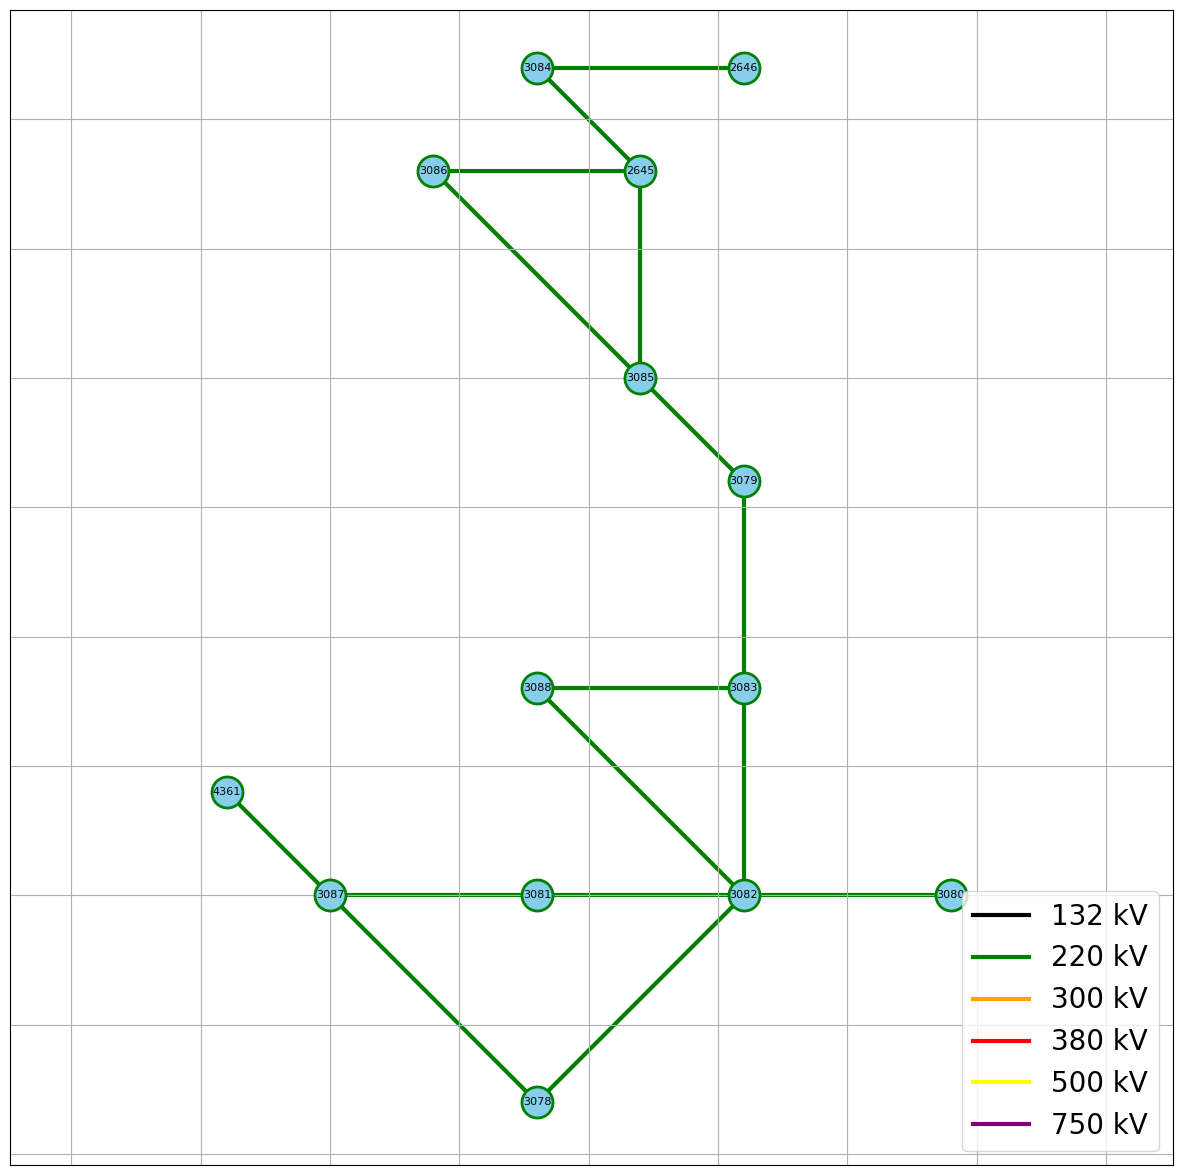

In [238]:

# Update positions based on optimized x and y coordinates
updated_pos = {node: (value(model.x_pos[node]), value(model.y_pos[node])) for node in G.nodes()}




draw_graph(G, updated_pos)



In [239]:
# Assuming 'G' is your graph and 'model' is your Pyomo model
# Updated positions based on optimized x and y coordinates
updated_pos = {node: (value(model.x_pos[node]), value(model.y_pos[node])) for node in G.nodes()}

# Initialize a list to store edge information along with the calculated angles
opt_edges_info = []

# Iterate through each edge in your graph
for edge in G.edges():
    node1, node2 = edge

    # Retrieve the updated positions for source and destination nodes
    new_src_x, new_src_y = updated_pos[node1]
    new_dst_x, new_dst_y = updated_pos[node2]

    # Calculate the angle using the updated positions
    angle = calculate_angle(new_src_x, new_src_y, new_dst_x, new_dst_y)

    formatted_angle = round(angle, 2)

    # Append the edge information and formatted angle to the list
    opt_edges_info.append({
        'Edge': edge,
        'Source': node1,
        'Destination': node2,
        'Angle (degrees)': formatted_angle  # Use the formatted angle
    })

# Convert the list of dictionaries to a pandas DataFrame for easy tabular display
opt_edges_info_df = pd.DataFrame(opt_edges_info)

# Print the DataFrame
#print(edges_info_df)
display(opt_edges_info_df)

,Edge,Source,Destination,Angle (degrees)
0,"(3078, 3082)",3078,3082,45.0
1,"(3078, 3087)",3078,3087,135.0
2,"(3082, 3088)",3082,3088,135.0
3,"(3082, 3083)",3082,3083,90.0
4,"(3083, 3088)",3083,3088,180.0
5,"(3081, 3087)",3081,3087,180.0
6,"(3081, 3082)",3081,3082,0.0
7,"(3087, 4361)",3087,4361,135.0
8,"(2645, 3086)",2645,3086,180.0
9,"(2645, 3085)",2645,3085,270.0


## Functions - Results

In [240]:
def count_octilinearity_violations(opt_edges_info):
    violations = 0
    for edge_info in opt_edges_info:
        edge = edge_info['Edge']
        angle = edge_info['Angle (degrees)']
        # Check if the angle is not an exact multiple of 45 (including 0)
        if angle % 45 != 0:
            print(f"Violation found: {edge} with angle {angle}°")
            violations += 1
            
    if violations == 0:
        print("No violations found.")
    else:
        print(f"Total Octilinear Violations: {violations}")
        
    return violations



octilinearity_violations = count_octilinearity_violations(opt_edges_info)



No violations found.


## Debugging

In [241]:
""" # Print initial positions
print("Initial Positions:")
#for node in model.Nodes:
print(f"Node {6193}: x = {model.x_init[6193]}, y = {model.y_init[6193]}")
print(f"Node {6398}: x = {model.x_init[6398]}, y = {model.y_init[6398]}\n\n")

# After solving the model

# Print final positions
print("\nFinal Positions:")
#for node in model.Nodes:
print(f"Node {6193}: x = {value(model.x_pos[6193])}, y = {value(model.y_pos[6193])}")
print(f"Node {6398}: x = {value(model.x_pos[6398])}, y = {value(model.y_pos[6398])}") """

' # Print initial positions\nprint("Initial Positions:")\n#for node in model.Nodes:\nprint(f"Node {6193}: x = {model.x_init[6193]}, y = {model.y_init[6193]}")\nprint(f"Node {6398}: x = {model.x_init[6398]}, y = {model.y_init[6398]}\n\n")\n\n# After solving the model\n\n# Print final positions\nprint("\nFinal Positions:")\n#for node in model.Nodes:\nprint(f"Node {6193}: x = {value(model.x_pos[6193])}, y = {value(model.y_pos[6193])}")\nprint(f"Node {6398}: x = {value(model.x_pos[6398])}, y = {value(model.y_pos[6398])}") '

In [242]:


def get_sorted_neighbours(G, node, pos, initial_neighbour):
    angles_neighbours = []
    src_x, src_y = pos[node]

    # Convert G to an undirected graph to consider all adjacent nodes
    G_undirected = G.to_undirected()

    # Calculate angles and sort neighbours
    for neighbour in G_undirected.neighbors(node):
        dst_x, dst_y = pos[neighbour]
        angle = calculate_angle(src_x, src_y, dst_x, dst_y)
        angles_neighbours.append((angle, neighbour))

    angles_neighbours.sort()
    sorted_neighbours = [neighbour for _, neighbour in angles_neighbours]

    # Start the sorted list with the initial neighbour
    if initial_neighbour in sorted_neighbours:
        start_index = sorted_neighbours.index(initial_neighbour)
        sorted_neighbours = sorted_neighbours[start_index:] + sorted_neighbours[:start_index]

    return sorted_neighbours

def check_order_and_sector_violations(G, updated_pos, ordered_neighbours_dict):
    violations_count = 0
    
    for node, initial_neighbours in ordered_neighbours_dict.items():
        if initial_neighbours:  # Make sure there is at least one neighbour
            initial_first_neighbour = initial_neighbours[0]
            optimized_neighbours = get_sorted_neighbours(G, node, updated_pos, initial_first_neighbour)
            
            # Check for order violations
            if initial_neighbours != optimized_neighbours:
                print(f"Order violation at node {node}. Initial order: {initial_neighbours}, Optimized order: {optimized_neighbours}")
                violations_count += 1
            
            # Check for sector violations
            angles = [round(calculate_angle(updated_pos[node][0], updated_pos[node][1],
                                            updated_pos[neighbour][0], updated_pos[neighbour][1]), 1)
                      for neighbour in optimized_neighbours]
            sectors = [int(angle // 45) for angle in angles]
            for i in range(len(sectors) - 1):
                if sectors[i] == sectors[i + 1] and angles[i] != angles[i + 1]:
                    print(f"Sector violation between nodes {optimized_neighbours[i]} and {optimized_neighbours[i + 1]} "
                          f"at node {node} in sector {sectors[i]}. Rounded angles: {angles[i]}, {angles[i + 1]}")
                    violations_count += 1
                    break  # Stop at the first violation for this node

    if violations_count == 0:
        print("No circular order violations found.")
    else:
        print(f"Total circular order violations: {violations_count}")
    
    return violations_count

# Example usage
circular_order_violations = check_order_and_sector_violations(G, updated_pos, ordered_neighbours_dict)


No circular order violations found.


In [243]:

def check_edge_spacing_violations(specified_edge_pairs, pos):
    intersecting_edge_pairs = []
    violations_count = 0

    for edge1, edge2 in specified_edge_pairs:
        # Get the positions for the source and target nodes of each edge from the 'pos' argument
        src_pos1, tgt_pos1 = pos[edge1[0]], pos[edge1[1]]
        src_pos2, tgt_pos2 = pos[edge2[0]], pos[edge2[1]]
        
        # Create LineString objects for each edge
        line1 = LineString([src_pos1, tgt_pos1])
        line2 = LineString([src_pos2, tgt_pos2])

        # Check if the two edges intersect and are not merely touching at endpoints
        if line1.intersects(line2) and not line1.touches(line2):
            print(f"Violation found between edge {edge1} and edge {edge2}")
            intersecting_edge_pairs.append((edge1, edge2))
            violations_count += 1

    if violations_count == 0:
        print("No edge spacing violations found.")
    else:
        print(f"Total edge spacing violations: {violations_count}")

    return violations_count


edge_cross_violations = check_edge_spacing_violations(non_intersecting_non_incident_edges, updated_pos)


No edge spacing violations found.


In [244]:

def display_results(stats, octilinearity_violations, circular_order_violations, edge_crossing_violations):
    # Construct the results DataFrame with the specified metrics
    results_df = pd.DataFrame([
        ['Solver Status', stats.get('Solver Status', 'N/A')],
        ['Objective Function Value', stats.get('Objective Value', 'N/A')],
        ['Computation Time (s)', stats.get('Solve Time (s)', 'N/A')],
        
        ['Number of Constraints', stats.get('Number of Constraints', 'N/A')],
        ['Number of Variables', stats.get('Number of Variables', 'N/A')],
        
        ['Total Number of Nodes', stats.get('Total Number of Nodes', 'N/A')],
        ['Total Number of Edges', stats.get('Total Number of Edges', 'N/A')],
        
        ['Octilinearity Violations', octilinearity_violations],
        ['Circular Order Violations', circular_order_violations],
        ['Edge Crossing Violations', edge_crossing_violations]
    ], columns=['Metric', 'Value'])
    
    # Display the DataFrame
    # If using a Jupyter Notebook, 'display()' will work directly.
    # In other environments, you might need to print the DataFrame or use another method to visualize it.
    display(results_df)



In [245]:

stats = extract_solver_stats(results, country_df)


display_results(stats, octilinearity_violations, circular_order_violations, edge_cross_violations)


,Metric,Value
0,Solver Status,ok
1,Objective Function Value,70
2,Computation Time (s),0.739064
3,Number of Constraints,3332
4,Number of Variables,921
5,Total Number of Nodes,14
6,Total Number of Edges,16
7,Octilinearity Violations,0
8,Circular Order Violations,0
9,Edge Crossing Violations,0
